In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

![](cloud_storage.png)

In [62]:
%%bigquery flights_df --verbose
SELECT airline,
  departure_airport,
  arrival_airport,
  departure_delay,
  CASE WHEN (arrival_delay >= 15) THEN 1 ELSE 0 END as delayed,
  EXTRACT(DAYOFWEEK FROM departure_date) as departure_weekday,
  EXTRACT(MONTH FROM departure_date) as departure_month,
  ROUND(ST_DISTANCE(ST_GEOGPOINT(departure_lon, departure_lat), ST_GEOGPOINT(arrival_lon, arrival_lat))/1000) as distance

FROM (
  SELECT
       PARSE_DATE("%Y-%m-%d", date) AS departure_date,
       airline,
       departure_airport,
       arrival_airport,
       departure_lat,
       departure_lon,
       arrival_lat,
       arrival_lon,
       departure_delay,
       arrival_delay
  FROM
    `bigquery-samples.airline_ontime_data.flights`)
  WHERE departure_date >= '2009-01-01' 
    AND departure_date <= '2009-12-31'
    AND departure_delay > 0

Executing query with job ID: e465164a-b89d-4efd-b77d-9f45e9b13987
Query executing: 8.14s
Query complete after 10.17s


In [63]:
flights_df.shape

(2302332, 8)

In [64]:
flights_df.sample(n = 5)

,airline,departure_airport,arrival_airport,departure_delay,delayed,departure_weekday,departure_month,distance
83457,NW,GRR,DTW,24.0,1,5,1,193.0
1133437,MQ,SGF,ORD,16.0,0,2,3,705.0
1799909,WN,MDW,LAS,1.0,0,1,5,2442.0
1000711,B6,BOS,JFK,23.0,1,7,5,300.0
1594596,UA,SFO,SEA,3.0,0,1,5,1094.0


## Exploratory Data Analysis & Data Preprocessing

In [6]:
flights_df.delayed.mean()

0.4509132479590259

44% are delayed

### Departure Delay

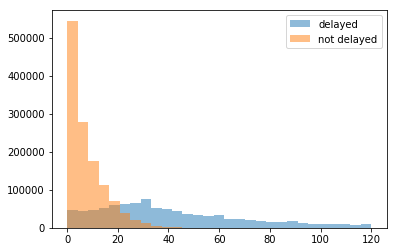

In [8]:
bins = np.linspace(0, 120, 30)
plt.hist(flights_df.query('delayed == 1')['departure_delay'], bins, alpha=0.5, label='delayed')
plt.hist(flights_df.query('delayed == 0')['departure_delay'], bins, alpha=0.5, label='not delayed')
plt.legend(loc='upper right')
plt.show()

In [39]:
flights_df['departure_delay_bin'] = pd.qcut(flights_df['departure_delay'], 10)

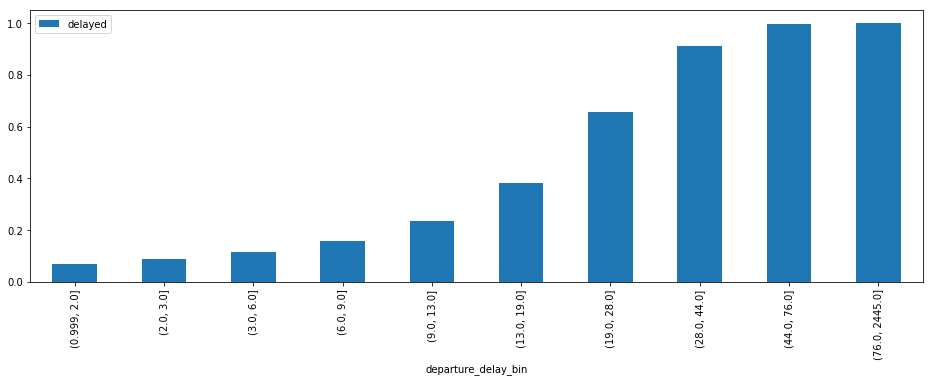

In [43]:
(flights_df
 .filter(['departure_delay_bin', 'delayed'])
 .groupby('departure_delay_bin')
 .agg('mean')
 .plot.bar(figsize = (16,5))
)

In [46]:
flights_df['departure_delay_bin'] = pd.cut(flights_df['departure_delay'], [0, 2, 3, 6, 9, 13, 19, 28, 44, 76, 120])

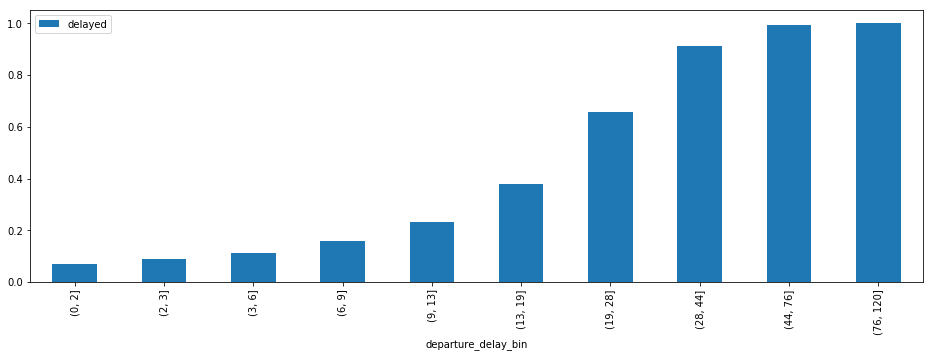

In [47]:
(flights_df
 .filter(['departure_delay_bin', 'delayed'])
 .groupby('departure_delay_bin')
 .agg('mean')
 .plot.bar(figsize = (16,5))
)

In [48]:
departure_delay_bins = flights_df['departure_delay_bin'].cat.categories

### Distance

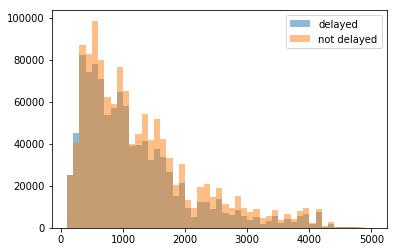

In [72]:
bins = np.linspace(100, 5000, 50)
plt.hist(flights_df.query('delayed == 1')['distance'], bins, alpha=0.5, label='delayed')
plt.hist(flights_df.query('delayed == 0')['distance'], bins, alpha=0.5, label='not delayed')
plt.legend(loc='upper right')
plt.show()

In [79]:
flights_df['distance_bin'] = pd.qcut(flights_df['distance'], 50)

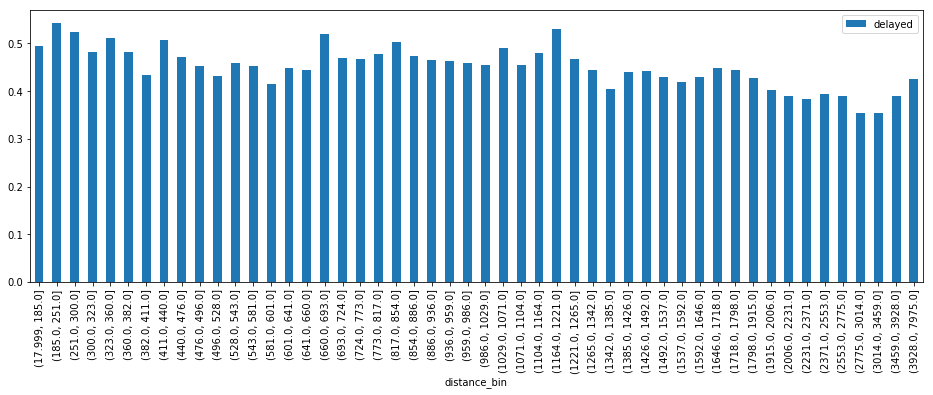

In [82]:
(flights_df
 .filter(['distance_bin', 'delayed'])
 .groupby('distance_bin')
 .mean()
 .plot.bar(figsize = (16,5))
)

The reason why we are binning is to make it easier for logistic regression to capture the trend in the data by assigning individual weights to different bin columns.

In [83]:
distance_bins = flights_df['distance_bin'].cat.categories

## Arrival Airport

We want to include these airports as feature that have an high impact on delay. All Airports might be too heavy. Let's look first for airport with frequent landings and chose the head and tail of this data.

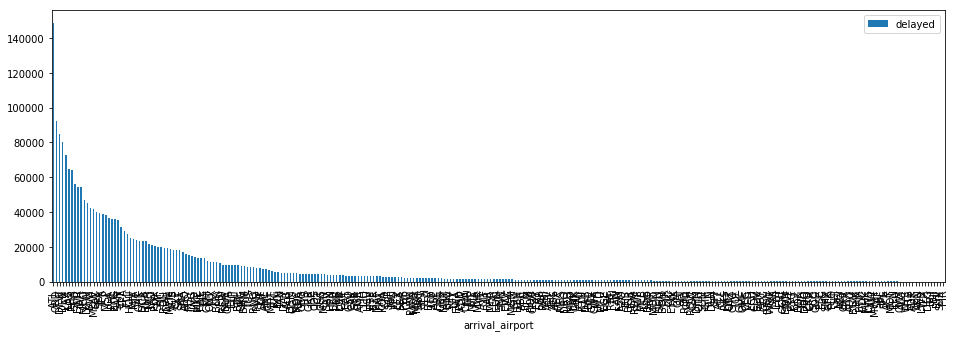

In [135]:
(flights_df
 .filter(['arrival_airport', 'delayed'])
 .groupby('arrival_airport')
 .count()
 .sort_values("delayed", ascending = False)
 .plot.bar(figsize = (16,5))
)

In [122]:
arrival_airport_stats = (pd.merge(
                    (flights_df
                     .filter(['arrival_airport', 'delayed'])
                     .groupby('arrival_airport')
                     .mean()
                     .rename(columns={'delayed': "mean_delay"})),
                    (flights_df
                     .filter(['arrival_airport', 'delayed'])
                     .groupby('arrival_airport')
                     .count()
                    .rename(columns={'delayed': "flight_count"})), 
                    on = 'arrival_airport'
                    )
                 .query('flight_count > 1000')
                 .sort_values("mean_delay", ascending = False)
                )

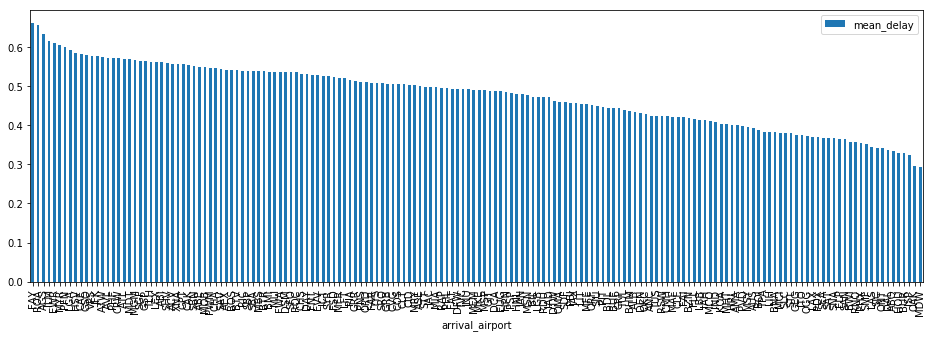

In [123]:
(arrival_airport_stats
 .filter(['mean_delay'])
 .plot.bar(figsize = (16,5))
)

In [143]:
high_traffic_airport_bins = pd.Series(arrival_airport_stats.index)

In [144]:
len(arrival_airport_bins)

166

### Airline

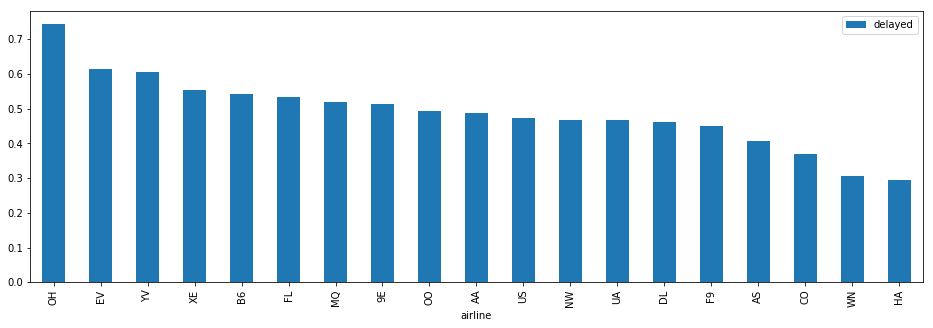

In [145]:
(flights_df
 .filter(['airline', 'delayed'])
 .groupby('airline')
 .agg('mean')
 .sort_values("delayed", ascending = False)
 .plot.bar(figsize = (16,5))
)

In [147]:
airline_delays = (flights_df
 .filter(['airline', 'delayed'])
 .groupby('airline')
 .agg('mean')
 .sort_values("delayed", ascending = False)
                         )

In [148]:
airline_bins = pd.Series(airline_delays.index)

In [150]:
len(airline_bins)

19

### Weekday

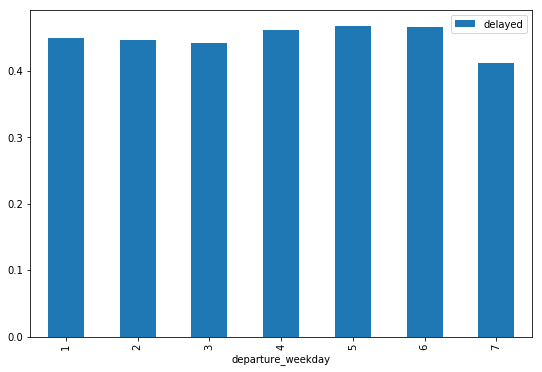

In [151]:
(flights_df
 .filter(['departure_weekday', 'delayed'])
 .groupby('departure_weekday')
 .agg('mean')
 .sort_values("departure_weekday", ascending = True)
 .plot.bar(figsize = (9,6))
)

In [152]:
weekday_delays = (flights_df
 .filter(['departure_weekday', 'delayed'])
 .groupby('departure_weekday')
 .agg('mean')
 .sort_values("delayed", ascending = False)
                         )

In [158]:
departure_weekday_bins = pd.Series(weekday_delays.index)

In [160]:
len(departure_weekday_bins)

7

### Month

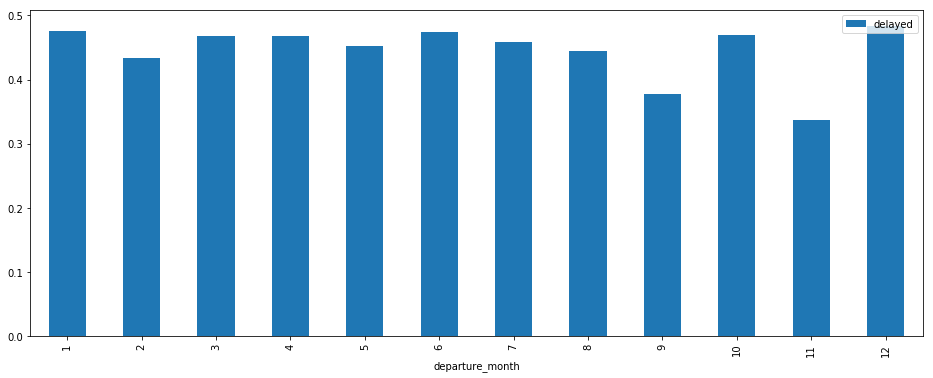

In [161]:
(flights_df
 .filter(['departure_month', 'delayed'])
 .groupby('departure_month')
 .agg('mean')
 .sort_values("departure_month", ascending = True)
 .plot.bar(figsize = (16,6))
)

In [163]:
month_delays = (flights_df
 .filter(['departure_month', 'delayed'])
 .groupby('departure_month')
 .agg('mean')
 .sort_values("delayed", ascending = True)
                 )

In [165]:
departure_month_bins = pd.Series(month_delays.index)

In [166]:
len(month_delays)

12

## Preprocessing Pipeline

In [172]:
def data_preprocessing(dataset):
    dataset = dataset.filter(['departure_delay', 'distance', 'arrival_airport', 'departure_airport', 'departure_month', 'departure_weekday', 'airline', 'delayed'])
    dataset['departure_delay_bin'] = pd.cut(dataset['departure_delay'], departure_delay_bins)
    dataset['departure_airport_bin'] = pd.Categorical(dataset['departure_airport'], high_traffic_airport_bins)
    dataset['arrival_airport_bin'] = pd.Categorical(dataset['arrival_airport'], high_traffic_airport_bins)
    dataset['departure_month_bin'] = pd.Categorical(dataset['departure_month'], departure_month_bins)
    dataset['departure_weekday_bin'] = pd.Categorical(dataset['departure_weekday'], departure_weekday_bins)
    dataset['airline_bin'] = pd.Categorical(dataset['airline'], airline_bins)
    dataset['distance_bin'] = pd.Categorical(dataset['distance'], distance_bins)

    dataset = dataset.filter(['departure_delay_bin', 'distance_bin', 'arrival_airport_bin', 'departure_airport_bin', 'departure_month_bin', 'departure_weekday_bin', 'airline_bin', 'delayed'])
    dataset = pd.get_dummies(dataset)
    return dataset


Assigning fixed categories to incoming data. Categories not found will all be 0 later.

In [173]:
flights_processed_df = data_preprocessing(flights_df)

In [174]:
flights_processed_df.shape

(2302332, 431)

In [175]:
flights_processed_df.head(5)

,delayed,"departure_delay_bin_(0, 2]","departure_delay_bin_(2, 3]","departure_delay_bin_(3, 6]","departure_delay_bin_(6, 9]","departure_delay_bin_(9, 13]","departure_delay_bin_(13, 19]","departure_delay_bin_(19, 28]","departure_delay_bin_(28, 44]","departure_delay_bin_(44, 76]",...,airline_bin_AA,airline_bin_US,airline_bin_NW,airline_bin_UA,airline_bin_DL,airline_bin_F9,airline_bin_AS,airline_bin_CO,airline_bin_WN,airline_bin_HA
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Model Training

### Training-Testing-Split

In [176]:
train_df = flights_processed_df.sample(frac=0.85,random_state=123)
test_df = flights_processed_df.drop(train_df.index)

train_labels = train_df.pop('delayed')
test_labels = test_df.pop('delayed')

In [230]:
# Initialize a Sequential model using TF.Keras API:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape = [len(train_df.keys())])])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
             )

In [231]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 431       
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


The model itself is still very simple (logistic regression). The complexity comes through the feature engineering and dummy variables. For the regression though this isn't a a problem because many of the computations will be 0 because it is essentially a weighted sum.

In [232]:
history = model.fit(train_df, train_labels, 
                    epochs = 4,
                    callbacks = [tf.keras.callbacks.TensorBoard("logs/logistic-regression")])

Train on 1956982 samples
Epoch 1/4
1956982/1956982 [==============================] - 254s 130us/sample - loss: 0.3540 - accuracy: 0.8534
Epoch 2/4
1956982/1956982 [==============================] - 262s 134us/sample - loss: 0.3544 - accuracy: 0.8508
Epoch 3/4
1956982/1956982 [==============================] - 247s 126us/sample - loss: 0.3695 - accuracy: 0.8440
Epoch 4/4
1956982/1956982 [==============================] - 248s 126us/sample - loss: 0.3856 - accuracy: 0.8385


### Performance evaluation of logistic regression on test data

In [233]:
test_predictions = model.predict(test_df).flatten()

test_predictions[:10]

array([0.60500073, 0.99999964, 0.99999976, 0.30231625, 0.1143648 ,
       0.04909125, 0.9427556 , 0.04572338, 0.08772826, 0.07298204],
      dtype=float32)

In [234]:
predicted_labels = (test_predictions > 0.5).astype(int)

predicted_labels[:10]

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [235]:
results_df = pd.DataFrame({'Predicted': predicted_labels, 'Actual': test_labels})
results_df.head(10)

,Actual,Predicted
2,0,1
4,1,1
8,1,1
16,0,0
29,0,0
33,0,0
36,1,1
41,0,0
60,1,0
78,1,0


In [236]:
confusion_matrix = pd.crosstab(results_df['Actual'], results_df['Predicted'], margins = True)

### Create the confusion matrix

**Accuracy**: How many observations did we label correctly out of all the observations? 

**Precision**: How many of those that we labeled as positive were actually positive?

**Recall**: Of all the positive class labels, how many of those did we correctly predict?

**F1 Score**: F1-Score is a combination of both recall and precision. The F1 Score is low if one measure is improved at the expense of the other. For example, if Precision is 1 and Recall is 0, the F1 score is 0.

In [237]:
confusion_matrix

Predicted,0,1,All
Actual,,,
0,167310,22184,189494
1,33864,121992,155856
All,201174,144176,345350


In [222]:
results_df.shape

(345350, 2)

In [238]:
confusion_matrix = pd.crosstab(results_df['Actual'], results_df['Predicted'], margins = True)

In [239]:
confusion_matrix

Predicted,0,1,All
Actual,,,
0,167310,22184,189494
1,33864,121992,155856
All,201174,144176,345350


In [240]:
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
TN = confusion_matrix.loc[0, 0]
FN = confusion_matrix.loc[1, 0]

In [241]:
accuracy = (TP+TN)/(TP+FP+FN+TN)
accuracy

0.8377066743883017

In [242]:
precision = TP/(TP+FP)
precision

0.8461325047164576

In [243]:
recall = TP/(TP+FN)
recall

0.7827225130890052

In [244]:
f1 = 2*(recall * precision) / (recall + precision)
f1

0.8131932593856654